# First, let's load the MNIST dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import requests # for alpha-binary digits

import torch
from torchvision import datasets, transforms # for MNIST

### Downloading, preprocessing & loading MNIST

In [4]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.MNIST('../data/processed', download=False, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# Download and load the test data
testset = datasets.MNIST('../data/processed', download=False, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [5]:
dataiter = iter(trainloader)

In [6]:
images, labels = dataiter.next()

In [7]:
print(images.shape, labels.shape) #loading 64 images of shape 28x28

torch.Size([64, 1, 28, 28]) torch.Size([64])


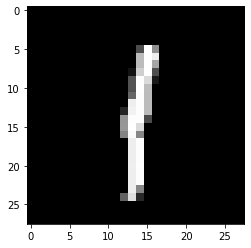

In [8]:
plt.imshow(images[0].squeeze(), cmap='Greys_r')

---

### Downloading AlphaBinary

In [9]:
# alpha_binary_mat = requests.get('https://cs.nyu.edu/~roweis/data/binaryalphadigs.mat')

In [10]:
# with open('../data/raw/alpha_binary.mat', 'wb') as f:
#     f.write(alpha_binary_mat.content)

### Preprocessing AlphaBinary

In [11]:
import scipy.io

In [12]:
file_mat = '../data/raw/alpha_binary.mat'
mat = scipy.io.loadmat(file_mat)

In [13]:
type(mat)

dict

In [14]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'dat', 'numclass', 'classlabels', 'classcounts'])

In [15]:
mat['dat'].shape # 39 samples for each of the 36 classes - 10 digits & 26 letters

(36, 39)

In [16]:
mat['classlabels'][0]

array([array(['0'], dtype='<U1'), array(['1'], dtype='<U1'),
       array(['2'], dtype='<U1'), array(['3'], dtype='<U1'),
       array(['4'], dtype='<U1'), array(['5'], dtype='<U1'),
       array(['6'], dtype='<U1'), array(['7'], dtype='<U1'),
       array(['8'], dtype='<U1'), array(['9'], dtype='<U1'),
       array(['A'], dtype='<U1'), array(['B'], dtype='<U1'),
       array(['C'], dtype='<U1'), array(['D'], dtype='<U1'),
       array(['E'], dtype='<U1'), array(['F'], dtype='<U1'),
       array(['G'], dtype='<U1'), array(['H'], dtype='<U1'),
       array(['I'], dtype='<U1'), array(['J'], dtype='<U1'),
       array(['K'], dtype='<U1'), array(['L'], dtype='<U1'),
       array(['M'], dtype='<U1'), array(['N'], dtype='<U1'),
       array(['O'], dtype='<U1'), array(['P'], dtype='<U1'),
       array(['Q'], dtype='<U1'), array(['R'], dtype='<U1'),
       array(['S'], dtype='<U1'), array(['T'], dtype='<U1'),
       array(['U'], dtype='<U1'), array(['V'], dtype='<U1'),
       array(['W'], dtyp

In [17]:
labels = np.array([label.item() for label in mat['classlabels'][0]])

In [18]:
labels

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], dtype='<U1')

---

In [19]:
images = mat['dat']

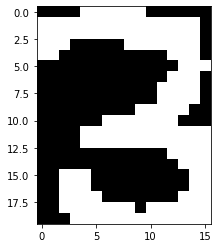

In [20]:
plt.imshow(images[3][0], cmap='Greys_r')

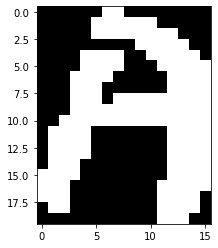

In [21]:
plt.imshow(images[10][0], cmap='Greys_r')

In [22]:
labels_array = []

In [23]:
for index, classe in enumerate(images):
    for image in classe:
        labels_array.append(labels[index])

labels_array = np.array(labels_array)

In [24]:
labels_array.shape[0] == 36*39

True

In [25]:
labels_array[0], labels_array[38], labels_array[39]

('0', '0', '1')

---

In [26]:
images[0][0].flatten().shape

(320,)

In [27]:
images[10][0].shape

(20, 16)

In [28]:
images[0, 1].shape

(20, 16)

In [29]:
def lire_alpha_digit(all_images, classes:list):
    data = []
    for cls in classes:
        for image in all_images[cls]:
            data.append(image.flatten().reshape(-1,1))
    
    return np.array(data)

All our data has been loaded and is ready to be used in a python data environment !

---

# Creating NN classes & methods

In [30]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [31]:
def logistic(x,w,b):
   xw = np.dot(x, w)
   replicated_b = np.tile(b, (x.shape[0], 1))

   return 1.0 / (1 + np.exp(- xw - b))

In [32]:
class RBM:
    
    def __init__(self, n_v, n_h, W=None, b=None, c=None, k=1):
        assert n_v != 0 and n_h != 0
        self.n_v = n_v
        self.n_h = n_h
        shape = (n_h, n_v)
        
        self.W = W if W is not None else np.random.uniform(-1, 1, size=shape)
        self.b = b if b is not None else np.zeros(n_v)
        self.c = c if c is not None else np.zeros(n_h)

        assert self.W.shape==shape and n_v == len(self.b) and n_h == len(self.c)
        
        self.k = k
        return
        
    def forward(self, V):
        n_sample, n_v = V.shape
        
        hsignal = np.dot(V, self.W.T) + self.c
        assert hsignal.shape == (n_sample, self.n_h)
        Hp = sigmoid(hsignal)
        
        #s = np.random.uniform(0, 1, size=hsignal.shape)
        #Hs = (s < Hp) * 1  # same as:
        Hs = np.random.binomial(1, Hp, size=Hp.shape)
        return Hp, Hs
    
    def backward(self, H):
        n_sample, n_h = H.shape
        
        vsignal = np.dot(H, self.W) + self.b
        assert vsignal.shape == (n_sample, self.n_v)
        #print(vsignal)
        Vp = sigmoid(vsignal)
        
        s = np.random.uniform(0, 1, size=vsignal.shape)
        Vs = (s < Vp) * 1
        return Vp, Vs

    def gibbs(self, V):  #return (probability, samples) of visible units
        Vs = V
        for i in range(self.k):
            Hp, Hs = self.forward(Vs)
            Vp, Vs = self.backward(Hs)
            
        return Hp, Hs, Vp, Vs
    
    def contrastive_divergence(self, V, learning=0.01):
        #set_trace()
        n_sample, n_v = V.shape
        
        Vs = V
        Hp, Hs, Vp_, Vs_ = self.gibbs(Vs)   # underscore _ refers to tilde for negative sample
        Hp_, Hs_ = self.forward(Vs_)

        Vs1 = np.mean(Vs, axis=0) 
        Vs2 = np.mean(Vs_, axis=0) 
        Hp1 = np.mean(Hp, axis=0)
        Hp2 = np.mean(Hp_, axis=0)
        Hs1 = np.mean(Hs, axis=0)
        Hs2 = np.mean(Hs_, axis=0)
        
        # note, there are variances in how to compute the gradients.
        # Hugo suggests:     h(v1)*v1 - h(v2)*v2
        # Bengio suggests:   h1*v1 - h(v2)*v2
        # My derivation:     h1(v1)*v1 - h2*v2 
        
        Eh_b = Vs1; Evh_b = Vs2      # Evh_b refers to the Expectation (over v and h) of -logP(v) gradient wrt b
        
        #Eh_c = Hs1; Evh_c = Hp2  # bengio
        Eh_c = Hp1; Evh_c = Hp2  # hugo
        #Eh_c = Hp1; Evh_c = Hs2  # Mine

        g_b = Evh_b - Eh_b  # gradient of -logP(v) wrt b
        g_c = Evh_c - Eh_c

        Eh_W = np.outer(Eh_c, Eh_b) 
        Evh_W = np.outer(Evh_c, Evh_b)
        g_W = Evh_W - Eh_W
    
        self.W -= g_W * learning
        self.b -= g_b * learning
        self.c -= g_c * learning        
        return
    
    def reconstruct(self, V):
        Hp, Hs = self.forward(V)
        Vp, Vs = self.backward(Hp)
        return Vp, Vs
    
    def train_model(self, train_data, n_epoch=100, batch_size=10, learning=0.01):
        for _ in range(n_epoch):
            MSE = []
            for x, y in train_data:
                self.contrastive_divergence(x.T, learning)
                reconstructed = self.reconstruct(x.T)
                MSE.append(((x.T - reconstructed)**2).sum()/len(x))
            print(f'MSE for epoch {_}: {np.array(MSE).mean()}')                      
        return

---

In [59]:
rbm = RBM(20*16, 20*8)

In [60]:
data = lire_alpha_digit(images, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [61]:
train_data = list(zip(data, labels_array[:39*2]))

In [62]:
rbm.train_model(train_data)

MSE for epoch 0: 0.427968443094409
MSE for epoch 1: 0.3500099245476203
MSE for epoch 2: 0.31103086209004016
MSE for epoch 3: 0.2827592951775687
MSE for epoch 4: 0.2665078214831117
MSE for epoch 5: 0.24677643377353561
MSE for epoch 6: 0.23882224341193015
MSE for epoch 7: 0.2279492659781437
MSE for epoch 8: 0.21589754475384168
MSE for epoch 9: 0.21328077935553574
MSE for epoch 10: 0.20717455902052684
MSE for epoch 11: 0.19955331877804092
MSE for epoch 12: 0.19475683335243962
MSE for epoch 13: 0.18708196102051242
MSE for epoch 14: 0.18308912379387313
MSE for epoch 15: 0.1776083703476986
MSE for epoch 16: 0.16922318488047133
MSE for epoch 17: 0.17095046479504802
MSE for epoch 18: 0.16347890061108636
MSE for epoch 19: 0.16245737007599953
MSE for epoch 20: 0.1571304657735012
MSE for epoch 21: 0.15301489740109156
MSE for epoch 22: 0.15076434408300676
MSE for epoch 23: 0.14571008492942011
MSE for epoch 24: 0.1432254401894068
MSE for epoch 25: 0.14562016513836193
MSE for epoch 26: 0.13594686725

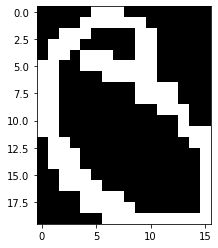

In [77]:
plt.imshow(data[39*0].reshape(20,16), cmap='Greys_r')

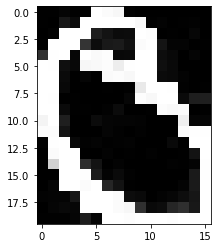

In [76]:
plt.imshow(rbm.reconstruct(data[39*0].T)[0].reshape(20,16), cmap='Greys_r')